In [36]:
import torch 
from torch import nn
from neuralop.models import FNO
from torch.optim import Adam

In [37]:
class Branch_net(nn.Module):
    def __init__(self,input,hidden,output):
        super(Branch_net,self).__init__()
            
        self._net = nn.Sequential(
                     nn.Linear(input, hidden),
                     nn.Tanh(),
                     nn.Linear(hidden, hidden),
                     nn.Tanh(),
                     nn.Linear(hidden, output),
                     nn.Tanh(),
                    )
    def forward(self,x):
       
        out=self._net(x)
        return out


class MFNO(nn.Module):
  def __init__(self):
      super(MFNO,self).__init__()
      self.bran_nn = Branch_net(2,50,1)
      self.fno = FNO(n_modes=(1,1),hidden_channels=12,in_channels=1,out_channels=1)

  def forward(self,x,condition):
      #对序列进行fno
      fno_out = self. fno(x) #[4, 3, 640, 300]，640是时间步

      out = self.bran_nn(condition)
      out = out.unsqueeze(-1)
      out = out.unsqueeze(-1)
      #([batch, 3, 1, 300])
      final_out = fno_out*out
      return final_out
  def Get_brann(self,Simulate,ini_data):
      fno_out = self. fno(ini_data) #[4, 3, 640, 300]，640是时间步
      brann = Simulate/fno_out
      return brann

      
      

In [38]:
# Instantiate the model
model = MFNO()

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = MFNO()  # 假设你已经定义和初始化了你的模型
print("Total number of trainable parameters:", count_parameters(model))


Total number of trainable parameters: 11708


In [7]:
initial_condition =torch.rand((1,1,30,30))
real_condition = torch.rand((1,2))
a=model(initial_condition,real_condition)

In [8]:
bran=model.Get_brann(a,initial_condition).detach()

In [10]:
def freeze_all(model):
    for param in model.parameters():
        param.requires_grad = True


In [11]:
freeze_all(model)

In [71]:
def gradient_objective_function(model, inputs, target):
    inputs.requires_grad_(True)
    outputs = model.bran_nn(inputs)

    t=target[0,0,0,1] # 因为重复
    loss = (outputs - t).pow(2).mean()  # 使用MSE作为损失函数
    
    loss.backward()
    grad=inputs.grad.data
    
    return grad, loss.item(),outputs.item()

In [89]:
import matplotlib.colors as mcolors

In [210]:
import matplotlib.pyplot as plt
class GradientInformedPSO:
    def __init__(self, model, gradient_func, target, num_particles=5, dims=2, epochs=2, lr=0.0001,w=0.5):
        self.model = model
        self.gradient_func = gradient_func
        self.target = target
        self.num_particles = num_particles
        self.dims = dims
        self.epochs = epochs
        self.lr = lr
        self.particles = torch.rand(num_particles, dims)*100   # 初始化粒子位置
        self.velocities = torch.zeros(num_particles, dims)  # 初始化粒子速度
        self.best_positions = torch.clone(self.particles)  # 个体最佳位置
        self.best_scores = torch.full((num_particles,), float('inf'))  # 个体最佳分数
        self.global_best_position = None
        self.global_best_score = float('inf')
        self.w = 0.5
               # 历史记录
        self.particles_history = []
        self.velocities_history = []
        self.global_best_score_history = []

    def optimize(self):
        for epoch in range(self.epochs):
         
            for i in range(self.num_particles):
                gradient, score,out_put = self.gradient_func(self.model, self.particles[i].unsqueeze(0), self.target)
                       # 历史记录
                self.particles_history.append(self.particles.clone())
                self.velocities_history.append(self.velocities.clone())
                self.global_best_score_history.append(self.global_best_score)
                if score < self.best_scores[i]:
                    self.best_scores[i] = score
                    self.best_positions[i] = self.particles[i]

                # 更新全局最佳位置
                if score < self.global_best_score:
                    self.global_best_score = score
                    self.global_best_position = self.particles[i]
                
                # 更新速度和位置
               
                r1, r2 = torch.rand(2)  # 随机数
                c1, c2 = 1.49445, 1.49445  # 学习因子，通常为1.49445
                self.velocities[i] = (
                    self.w * self.velocities[i] +
                    c1 * r1 * (self.best_positions[i] - self.particles[i]) +
                    c2 * r2 * (self.global_best_position - self.particles[i]) +
                    self.lr * gradient.squeeze()
                )



                self.particles[i] -= self.velocities[i]  # 更新位置

            print("epoch=", epoch,self.global_best_position,self.global_best_score)
            print("brann_out",out_put)

        return self.global_best_position.cpu().numpy(), self.global_best_score
   
    
    def visualize(self):
        import matplotlib.pyplot as plt
        import matplotlib.colors as mcolors
        fig, ax = plt.subplots(figsize=(6, 5))
        cmap = plt.cm.viridis  # Choose a colormap
        
        # Normalize the epoch numbers for color mapping
        norm = mcolors.Normalize(vmin=0, vmax=self.epochs)

        # Plot the trajectories of each particle
        for particle_index in range(self.num_particles):
            # Generate a color for each particle inside the loop where it's used
            particle_color = cmap(norm(particle_index / self.num_particles))
            
        for epoch in range(1, self.epochs):
            # Previous and current position
            prev_pos = self.particles_history[epoch-1][particle_index].cpu().numpy()
            curr_pos = self.particles_history[epoch][particle_index].cpu().numpy()
            
            # Draw the trajectory segment
            ax.plot([prev_pos[0], curr_pos[0]], [prev_pos[1], curr_pos[1]], color=particle_color)

        # Draw the velocity vectors for the last epoch
        positions = self.particles_history[-1].cpu().numpy()
        velocities = self.velocities_history[-1].cpu().numpy()
        for i in range(self.num_particles):
            # Fix: Correctly use the color for each particle inside the loop
            particle_color = cmap(norm(i / self.num_particles))
            ax.quiver(positions[i, 0], positions[i, 1], velocities[i, 0], velocities[i, 1], color=particle_color, angles='xy', scale_units='xy', scale=1, alpha=0.5)

 
        plt.show()
      
     

     

# 目标值
target_output = bran

# 创建PSO优化器实例
pso_optimizer = GradientInformedPSO(model, gradient_objective_function, target_output, epochs=2)

# 执行优化
best_position, best_score = pso_optimizer.optimize()
print(f"Best position (a, b): {best_position}")
print(f"Best score (distance from target): {best_score}")
#pso_optimizer.visualize()

epoch= 0 tensor([13.9868, 37.3629]) 0.0014375736936926842
brann_out -0.0010663230204954743
epoch= 1 tensor([58.6436, 79.4686]) 0.00015342143888119608
brann_out -0.0010663230204954743
Best position (a, b): [58.643642 79.46863 ]
Best score (distance from target): 0.00015342143888119608


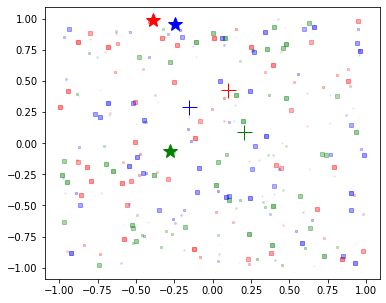

In [211]:
# Adjusting the code to have three different colors for each particle, starting with circles
# and ending with stars. The trajectory color starts light and ends dark near the star.

# Create the figure and axis again
fig, ax = plt.subplots(figsize=(6, 5))

# Define colors for the particles
colors = ['red', 'green', 'blue']

# Plot trajectories with increasing line width and color gradient
for particle_index, color in enumerate(colors):
    for epoch in range(1, epochs):
        prev_pos = particles_history[epoch-1][particle_index]
        curr_pos = particles_history[epoch][particle_index]
        #line_width =  (epoch / epochs)   # Line width increases over time
        # Lighten the color as the epoch decreases, darken as it increases
        color_intensity = 0.5*epoch / epochs   # Color darkens over time
   
        ax.plot(curr_pos[0], curr_pos[1], marker='s', color=color, markersize=10*color_intensity,alpha= color_intensity)

# Mark starting positions with a circle
for particle_index, color in enumerate(colors):
    start_pos = particles_history[0][particle_index]

    ax.plot(start_pos[0], start_pos[1], marker='+', color=color, markersize=15,alpha= 1)

# Mark ending positions with a star
for particle_index, color in enumerate(colors):
    end_pos = particles_history[-1][particle_index]
    ax.plot(end_pos[0], end_pos[1], marker='*', color=color, markersize=15)

# Setting aspect ratio to equal for correct sdisplay of markers


# Show the plot
plt.show()


In [139]:
 outputs = model.bran_nn(torch.tensor([82.89249, 85.94301]))
outputs

tensor([-0.0401], grad_fn=<TanhBackward0>)

In [181]:
particles_history.shape

AttributeError: 'list' object has no attribute 'shape'

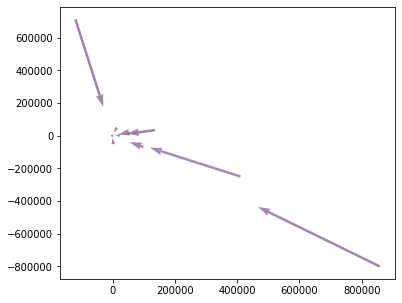

In [140]:
pso_optimizer.visualize()